## CODE FOR DRAFT TO RUN (NO NEED TO COPY IT)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

import json

FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)
df.head()
df_r1 = df[df["release_year"].notna()]

## CODE TO KEEP

/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_32136/1522691315.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.get_figure().show()


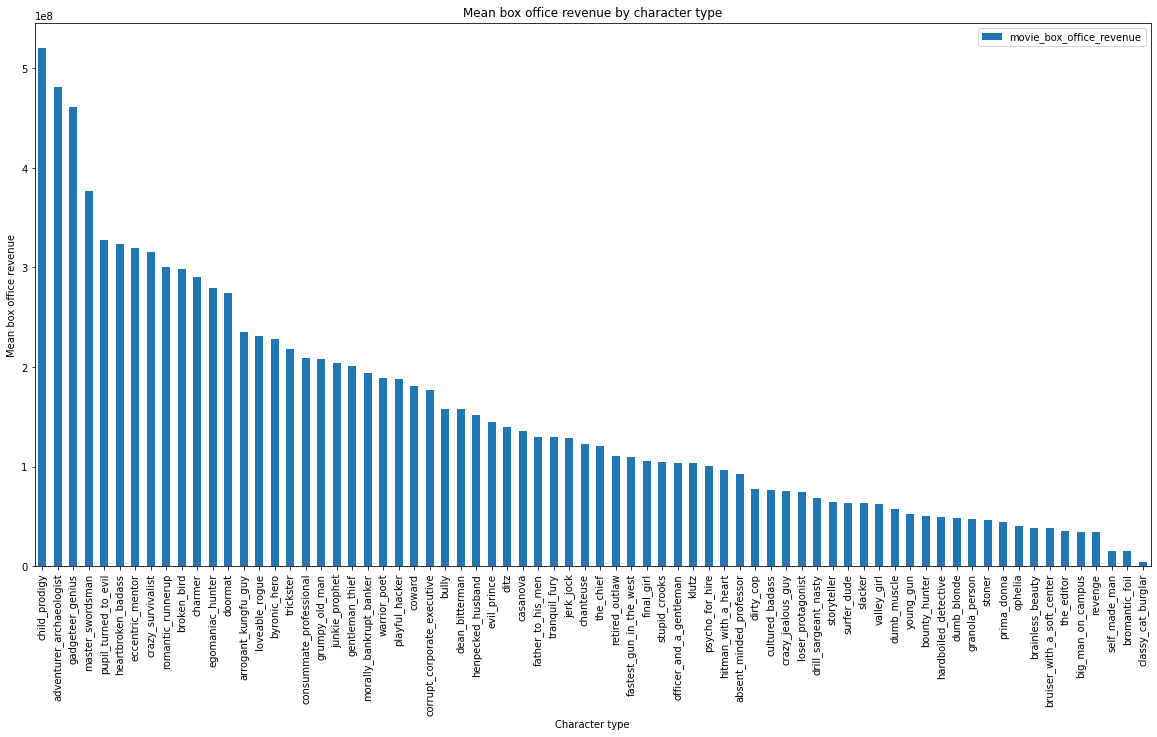

In [2]:
#### Character type
COLOMNS_NAMES_TV_TROPES = [
    "character_type",
    "object"
]
df_tvtropes = pd.read_csv(FOLDER_PATH + 'tvtropes.clusters.txt', sep='\t', header=None, names=COLOMNS_NAMES_TV_TROPES)

# Treats the object column to turn it into multiple columns
df_tvtropes["character_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["char"], axis=1)
df_tvtropes["movie_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["movie"], axis=1)
df_tvtropes["freebase_id"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["id"], axis=1)
df_tvtropes["actor_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["actor"], axis=1)
df_tvtropes.drop("object", axis=1, inplace=True)

df_tvtropes.head()

# We remove the movies with no box office value (removed 27030 movies) 34617-7587=27030
df_box_office = df[df["movie_box_office_revenue"].notna()]
df_character_type = df_tvtropes.copy()

# We add the box office revenue for each movie in the character type dataframe
df_character_type["movie_box_office_revenue"] = df_character_type["movie_name"].apply(lambda movie_name: df_box_office[df_box_office["movie_name"] == movie_name]["movie_box_office_revenue"].values)
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else 0)
#TODO: drop movies with 0 as box office_revenue

# We group the dataframe by character type and take the mean of the box office revenue
df_character_type = df_character_type.groupby("character_type")
plt = df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False).plot(kind="bar", figsize=(20, 10))
plt.set_xlabel("Character type")
plt.set_ylabel("Mean box office revenue")
plt.set_title("Mean box office revenue by character type")
plt.get_figure().savefig("mean_box_office_revenue_by_character_type.png")
plt.get_figure().show()


## DRAFT STUFF

In [3]:
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else None) 
# import numpy as np
# df_character_type.groupby("character_type")
#.aggregate(np.mean)
# , "character_name", "movie_name", "freebase_id", "actor_name"
df_character_type.groupby("character_type").mean().sort_values("movie_box_office_revenue", ascending=False).plot(kind="bar", figsize=(20, 10))

KeyError: 0

In [ ]:

#### Runtime evolution
# Cleaning runtime data

# soldiers of freedom is indeed a 6h movie
# Unsung heroes is actually 98 min long
# Swallow the sun is a TV series so indeed really long...
# heimat est une serie de films...
# once a eagle is a mini serie
df_r1.sort_values("movie_runtime", ascending=False)[["movie_name", "movie_runtime"]].head(30)

# Remove outliers
# We remove movies with a runtime higher than 6h as it corresponds mostly to TV series, mini series and errors (removed 20 movies)
df_runtime = df_r1[df_r1["movie_runtime"] < 450]
def group_by_decade(df):
    df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)
    return df

df_runtime.boxplot(column="movie_runtime", by="release_year", figsize=(20, 10))

df_runtime_decade = group_by_decade(df_runtime)
df_runtime_decade.boxplot(column="movie_runtime", by="decade", figsize=(20, 10))


# We remove the movies without value for the box office (26830 movies removed, 7461 kept)
df_runtime = df_runtime[df_runtime["movie_box_office_revenue"].notna()] 
#df_runtime.boxplot(column="movie_runtime", by="movie_box_office_revenue", figsize=(20, 10))

#df_runtime.sort_values("movie_box_office_revenue", ascending=False)[["movie_name", "movie_runtime", "movie_box_office_revenue"]].head(50)

def group_by_thousand(df):
    df["thousand"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000)*1000)
    return df

def group_by_million(df):
    df["million"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000000)*1000000)
    return df

#df_runtime_thousand = group_by_thousand(df_runtime)
#df_runtime_thousand.boxplot(column="movie_runtime", by="thousand", figsize=(20, 10))

df_runtime_million = group_by_million(df_runtime)
#df_runtime_million.boxplot(column="movie_runtime", by="million", figsize=(20, 10))


# box_offices = df_runtime_million.movie_box_office_revenue.apply(lambda x: int(x/1000000)*1000000).value_counts()
# fig, ax = plt.subplots()
# ax.bar(box_offices.index, box_offices.values, color="blue")
# ax.set_xlabel("Box office")
# ax.set_ylabel("Number of movies")
# ax.set_title("Movie box office")
# plt.xticks(rotation=90)
# plt.show()
# box_offices

#### Number of character evolution
# Clean cast data
# We remove the movies with no cast (removed 17703 movies)
df_cast = df_r1[df_r1["cast"].notna()]
df_cast["cast_length"] = df_cast["cast"].apply(lambda cast: len(cast))
#df_cast.boxplot(column="cast_length", by="release_year", figsize=(20, 10))
type(df_cast["cast"].head(1).values[0])

#### Ratio Men/Women evolution
# TODO: try to do a graph nb of women in cast by year (or by decade) and another one with nb of men
def get_nb_actors(cast):
    return len(cast)

def get_nb_female_actors(cast):
    return None
